In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

Level 1 SDG methods on Law School Admissions Bar Passage Dataset

The goal of SDG is mitigating bias in therms of gender, race and background

In [2]:
#load the dataset
dataset_path = 'C:/Users/20181588/Desktop/AA SDG/synthetic-data-generation/Law School Admissions Bar Passage/Dataset/bar_pass_prediction.csv'
original_data = pd.read_csv(dataset_path)
# Make a copy of the dataset
data_full = original_data.copy()

Drop useless features

Features that are useful are:

ugpa - This one stands for undergraduate gpa. Every other feature with gpa in it either perfectly correlates or perfectly negatively correlates with ugpa and this is the one I decided to keep.

decile1, decile1b, decile3 - These features represent the law school rankings by decile of each candidate in years 1 and 3 (and I’m assuming year one second semester, but I can’t be sure about that).

lsat - This feature is obviously the LSAT score of each candidate, but oddly it’s not formatted in the 120 to 180 score range of the actual LSAT. That said it has a strong correlation to whether someone passed the bar and, well, the feature is called lsat!

grad - This seems to be whether the student who took the bar exam graduated from law school. It’s a binary variable and there are very few 0s, so that makes the most sense. (Special kudos to the 65 students surveyed who didn’t graduate law school, but still managed to pass the bar!)

fulltime - Was the student a full-time student.

fam_inc - This feature is family income by quintile.

tier - What tier law school did the student attend by quintile.

race1 - Categorizes students by race. Of all the race variables this was the most complete, so it’s the one I kept. All the information contained in the other race variables are contained in race1.

sex - student gender.

pass_bar - This is the target variable. Did the student pass the bar.

In [3]:
data_full.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

In [4]:
# List of columns to keep
columns_to_keep = [
    'pass_bar', 'bar_passed', 'ugpa', 'decile1', 'decile1b', 
    'decile3', 'lsat', 'grad', 'fulltime', 'fam_inc', 
    'tier', 'race1', 'sex'
]

# Creating a new DataFrame with only the selected features
data = data_full[columns_to_keep].copy()

In [5]:
data.columns

Index(['pass_bar', 'bar_passed', 'ugpa', 'decile1', 'decile1b', 'decile3',
       'lsat', 'grad', 'fulltime', 'fam_inc', 'tier', 'race1', 'sex'],
      dtype='object')

Basic Dataset Exploration

In [6]:
# Convert 'grad' to binary where 'Y' is 1 and anything else is 0
data['grad'] = data['grad'].apply(lambda x: 1 if x == 'Y' else 0)

# Verify the transformation
print(data['grad'].head())


0    1
1    1
2    1
3    1
4    1
Name: grad, dtype: int64


In [7]:
data.head()

,pass_bar,bar_passed,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,sex
0,1,True,3.5,10.0,10.0,10.0,44.0,1,1.0,5.0,4.0,white,1.0
1,1,True,3.5,5.0,5.0,4.0,29.0,1,1.0,4.0,2.0,white,1.0
2,1,True,3.5,3.0,3.0,2.0,36.0,1,1.0,1.0,3.0,white,2.0
3,1,True,3.5,7.0,7.0,4.0,39.0,1,1.0,4.0,3.0,white,2.0
4,1,True,3.5,9.0,9.0,8.0,48.0,1,1.0,4.0,5.0,white,2.0


In [8]:
# Basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22407 entries, 0 to 22406
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pass_bar    22407 non-null  int64  
 1   bar_passed  22407 non-null  bool   
 2   ugpa        22407 non-null  float64
 3   decile1     21315 non-null  float64
 4   decile1b    20803 non-null  float64
 5   decile3     20803 non-null  float64
 6   lsat        22407 non-null  float64
 7   grad        22407 non-null  int64  
 8   fulltime    22373 non-null  float64
 9   fam_inc     22118 non-null  float64
 10  tier        22311 non-null  float64
 11  race1       22391 non-null  object 
 12  sex         22402 non-null  float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 2.1+ MB


In [9]:
# Statistical summary of the numerical features
data.describe()

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,sex
count,22407.000000,22407.000000,21315.000000,20803.000000,20803.000000,22407.000000,22407.000000,22373.000000,22118.000000,22311.000000,22402.000000
mean,0.947829,3.215451,5.708234,5.528481,5.525934,36.767907,0.995894,1.076878,3.466046,3.768814,1.561378
std,0.222377,0.404073,2.783098,2.854800,2.851286,5.463248,0.063947,0.266404,0.856425,1.179375,0.496229
min,0.000000,1.500000,1.000000,1.000000,1.000000,11.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,3.000000,3.000000,3.000000,3.000000,33.000000,1.000000,1.000000,3.000000,3.000000,1.000000
50%,1.000000,3.200000,6.000000,6.000000,6.000000,37.000000,1.000000,1.000000,4.000000,4.000000,2.000000
75%,1.000000,3.500000,8.000000,8.000000,8.000000,41.000000,1.000000,1.000000,4.000000,5.000000,2.000000
max,1.000000,3.900000,10.000000,10.000000,10.000000,48.000000,1.000000,2.000000,5.000000,6.000000,2.000000


In [10]:
# Check for missing values
print(data.isnull().sum())

pass_bar         0
bar_passed       0
ugpa             0
decile1       1092
decile1b      1604
decile3       1604
lsat             0
grad             0
fulltime        34
fam_inc        289
tier            96
race1           16
sex              5
dtype: int64


Data Exploration Distributions

In [11]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

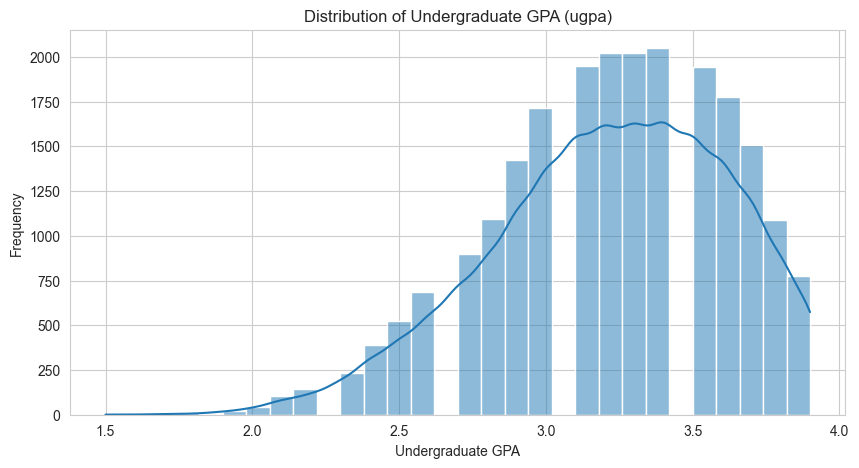

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(data['ugpa'], kde=True, bins=30)
plt.title('Distribution of Undergraduate GPA (ugpa)')
plt.xlabel('Undergraduate GPA')
plt.ylabel('Frequency')
plt.show()

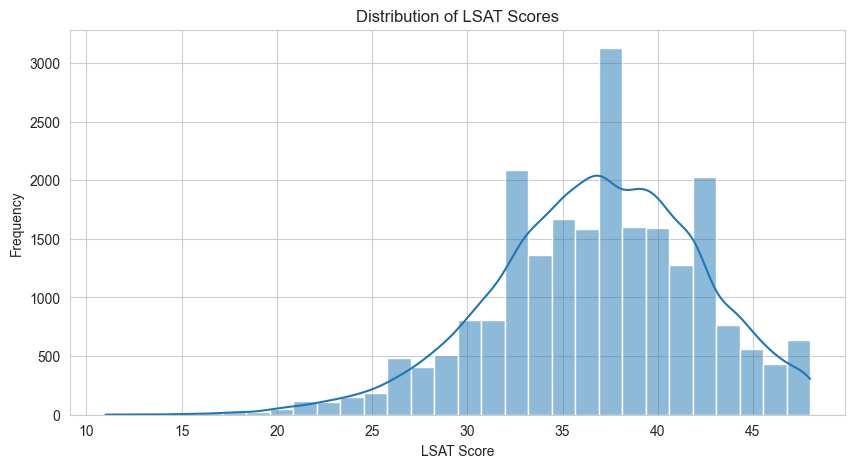

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(data['lsat'], kde=True, bins=30)
plt.title('Distribution of LSAT Scores')
plt.xlabel('LSAT Score')
plt.ylabel('Frequency')
plt.show()

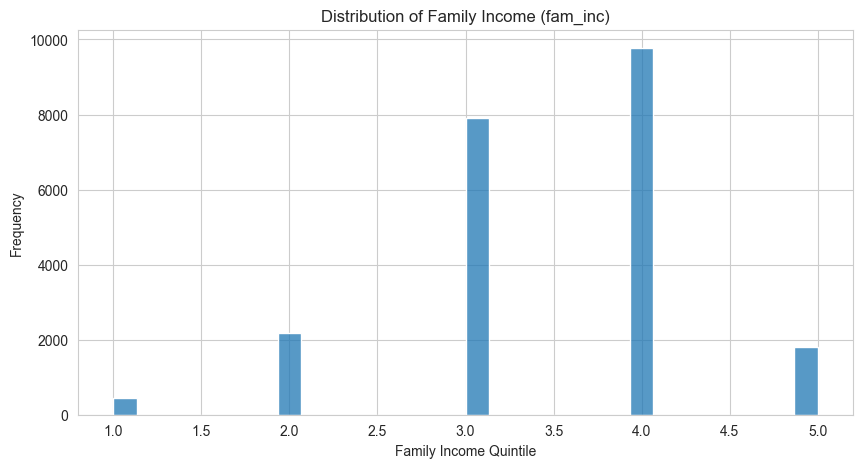

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(data['fam_inc'], kde=False, bins=30)
plt.title('Distribution of Family Income (fam_inc)')
plt.xlabel('Family Income Quintile')
plt.ylabel('Frequency')
plt.show()

First Quintile (1.0): This is the lowest income group and represents the bottom 20% of the population in terms of income.
Second Quintile (2.0): This group is above the lowest 20% but below the median, representing families with income greater than 20% of the population but less than 40%.
Third Quintile (3.0): This is the middle income group, indicating families with income greater than 40% but less than 60% of the population, essentially the middle class.
Fourth Quintile (4.0): This quintile represents families with income greater than 60% but less than 80% of the population, typically upper-middle-class families.
Fifth Quintile (5.0): This is the highest income group, representing the top 20% of the population in terms of income.

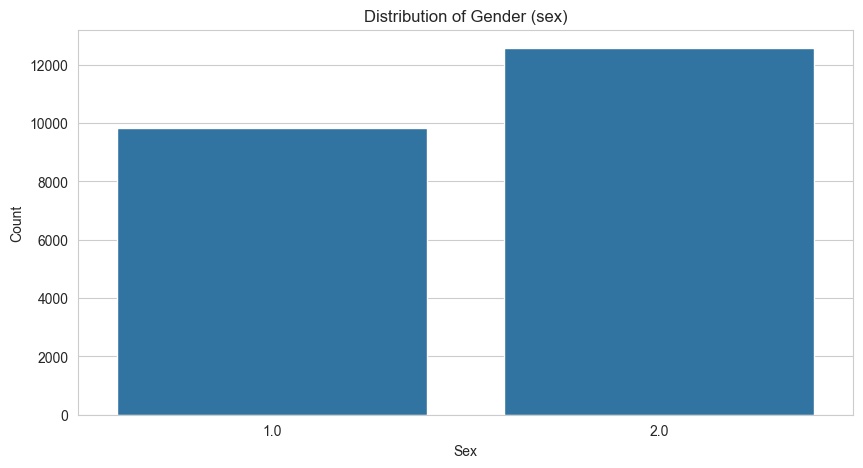

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(x='sex', data=data)
plt.title('Distribution of Gender (sex)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

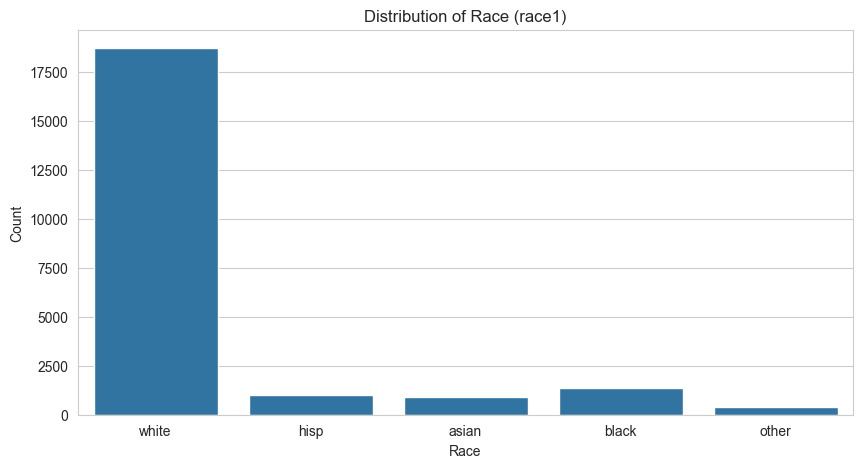

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(x='race1', data=data)
plt.title('Distribution of Race (race1)')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

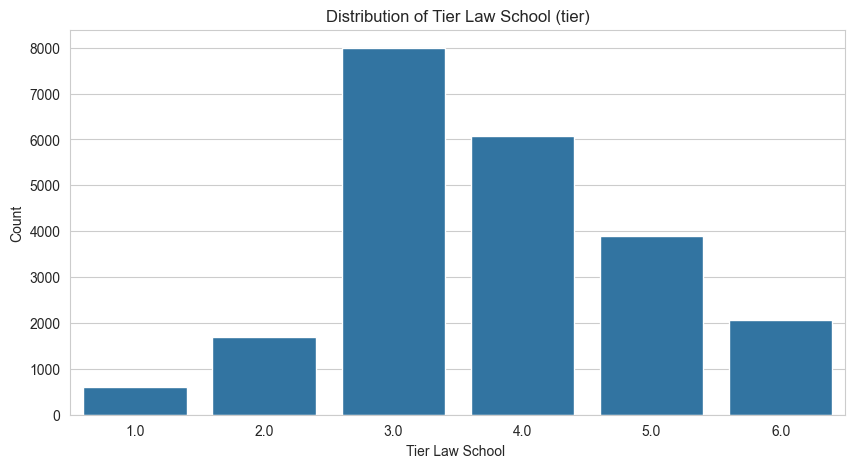

In [23]:
plt.figure(figsize=(10, 5))
sns.countplot(x='tier', data=data)
plt.title('Distribution of Tier Law School (tier)')
plt.xlabel('Tier Law School ')
plt.ylabel('Count')
plt.show()

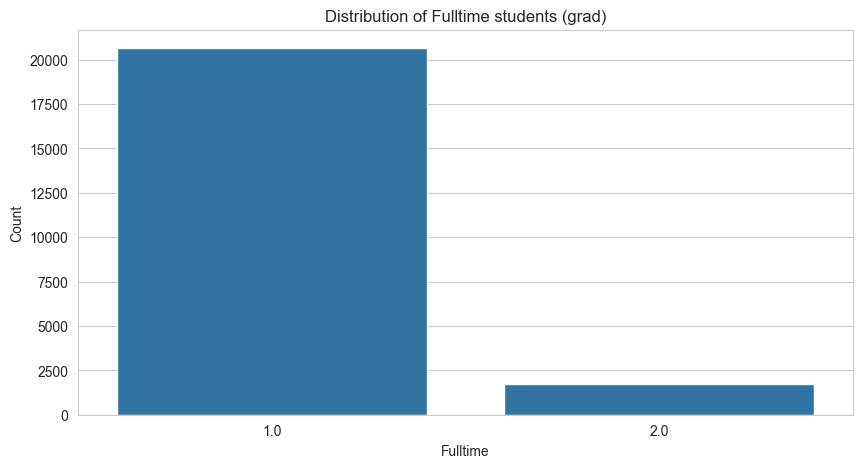

In [28]:
plt.figure(figsize=(10, 5))
sns.countplot(x='fulltime', data=data)
plt.title('Distribution of Fulltime students (grad)')
plt.xlabel('Fulltime')
plt.ylabel('Count')
plt.show()

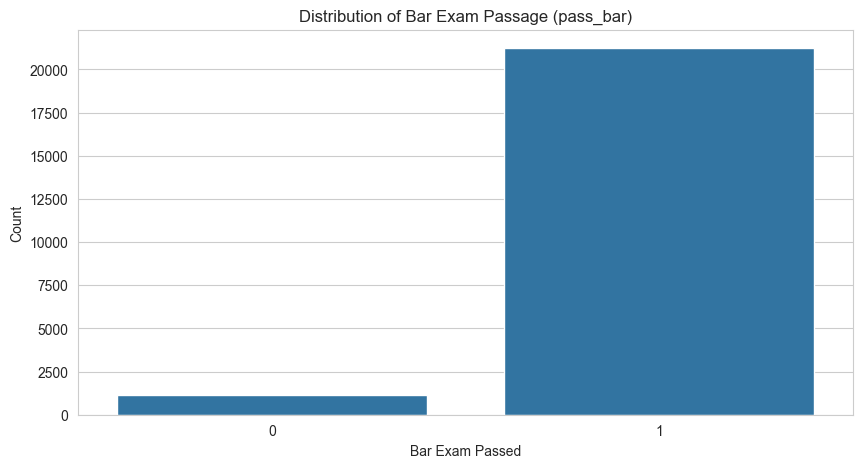

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(x='pass_bar', data=data)
plt.title('Distribution of Bar Exam Passage (pass_bar)')
plt.xlabel('Bar Exam Passed')
plt.ylabel('Count')
plt.show()

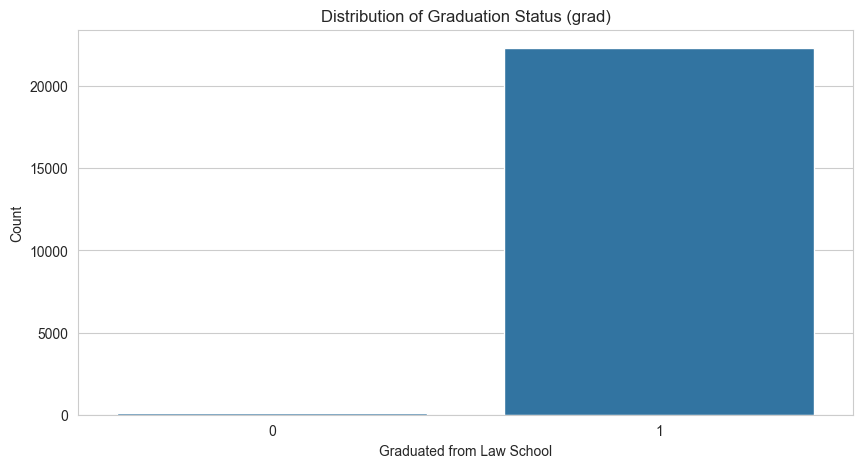

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(x='grad', data=data)
plt.title('Distribution of Graduation Status (grad)')
plt.xlabel('Graduated from Law School')
plt.ylabel('Count')
plt.show()

Data Exploration Correlations

ValueError: could not convert string to float: 'white'

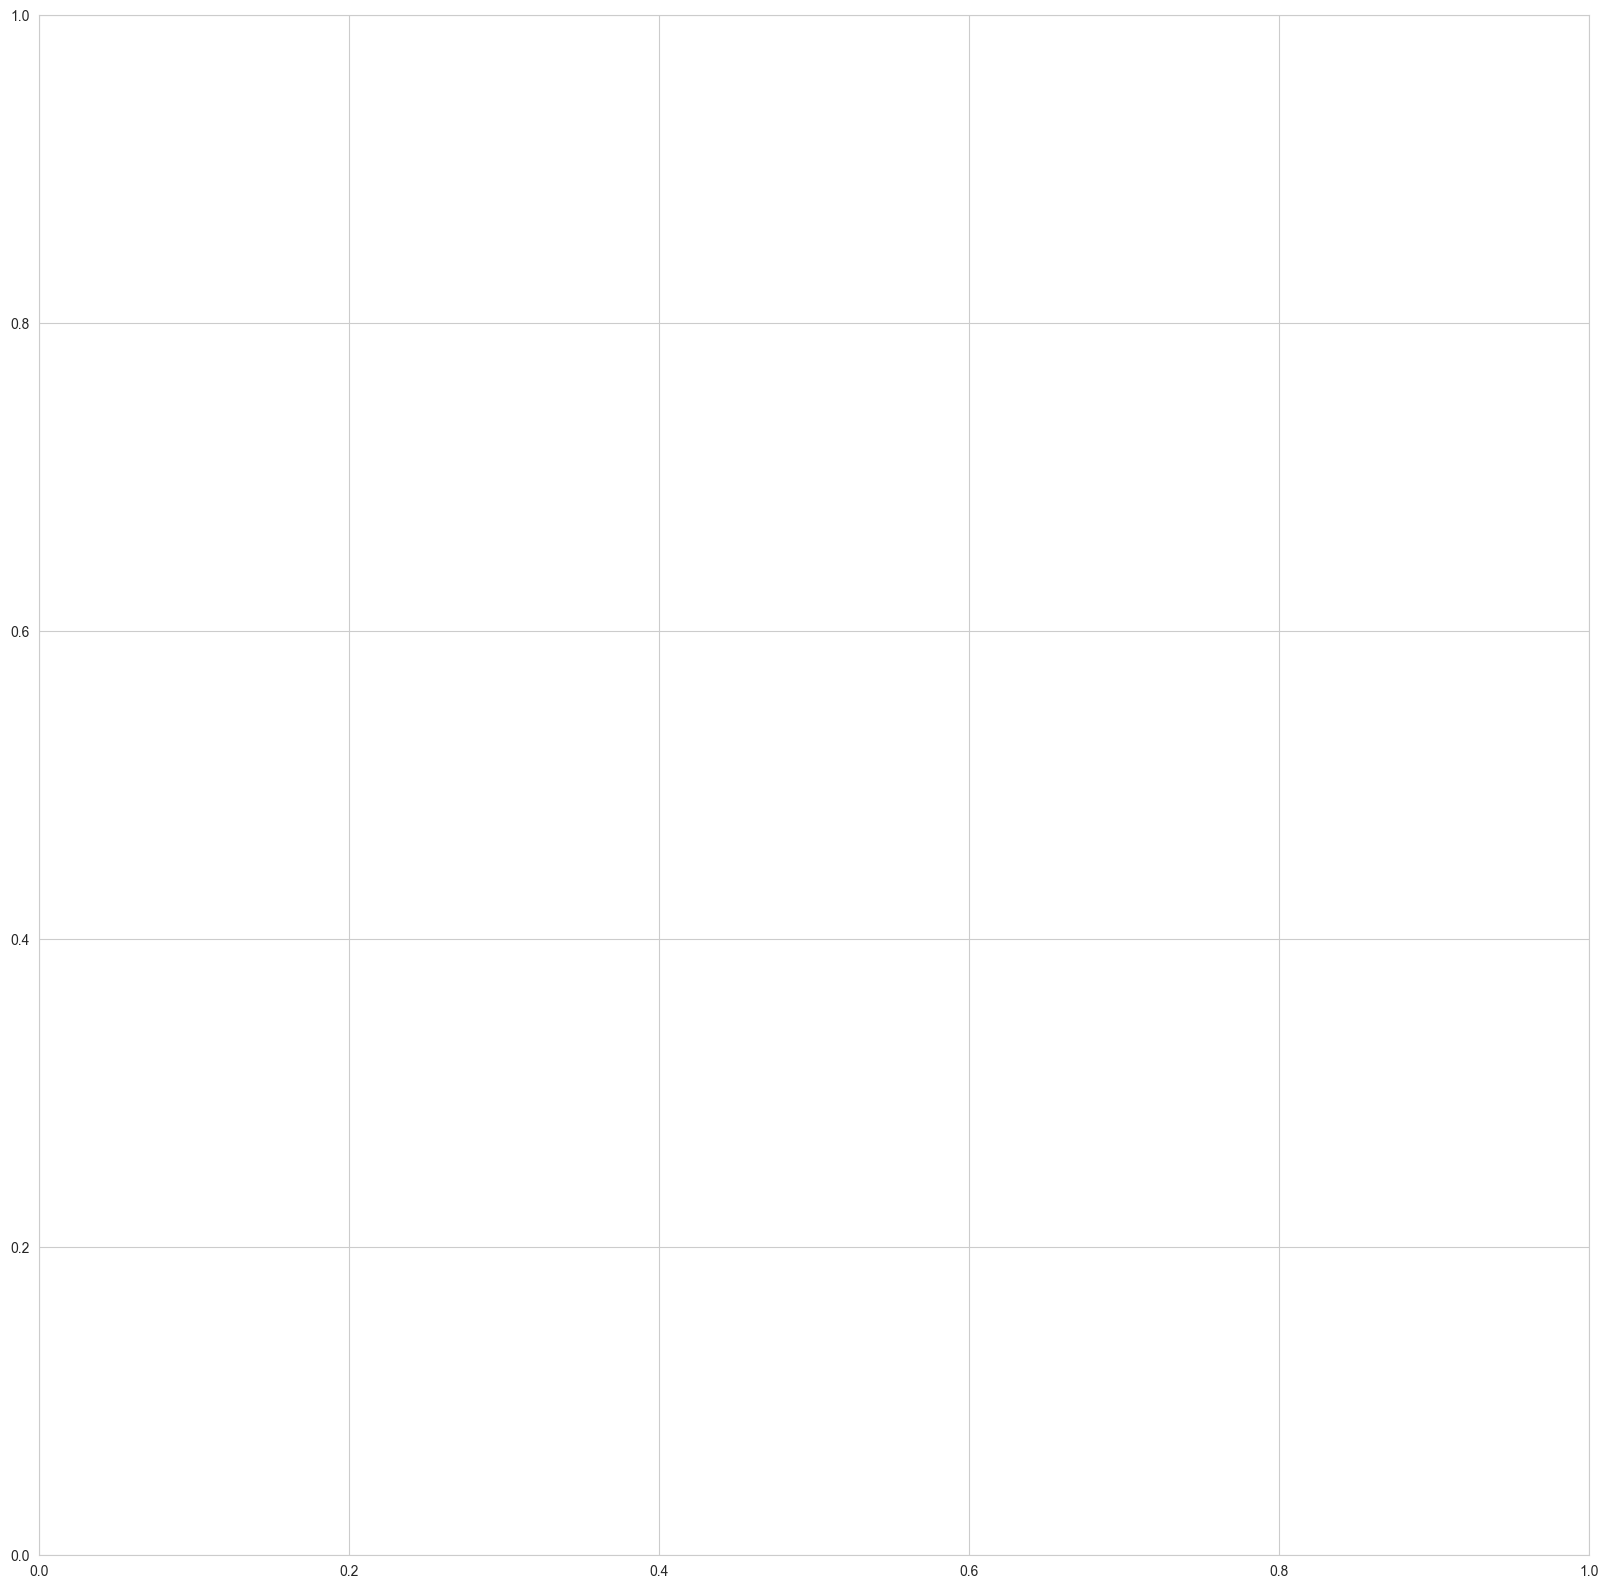

In [27]:
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

Data Exploration - Pass Rate to Gender, Race & Family Income

Data Exploration - Graduated from Law School to Gender, Race & Family Income

SDG - Synthetic Minority Over-sampling Technique (SMOTE)

SDG - Resampling-based Methods - Undersampling

SDG - Resampling-based Methods - Oversampling

SDG - Modification of Resampled Samples - Interpolation

SDG - Modification of Resampled Samples - Adding small prtyrbations